# Loading the data

In [4]:
import pandas as pd
import numpy as np
import h2o
from h2o.automl import H2OAutoML
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

# Initialize H2O (if needed)
# h2o.init(max_mem_size="8G")  

data_path = "/kaggle/input/s/df_variance_subset.csv"
df = pd.read_csv(data_path)
print(f"Data loaded with shape: {df.shape}")

target = "Potency_Change_Label"  # adjust to your actual target name
non_feature_cols = [
    "canonical_smiles_1", "canonical_smiles_2",
    "Potency_Change", "Potency_Change_Category", "Potency_Change_Label"
]

# Toggle the following flag to include or exclude the preselected feature subset.
use_feature_subset = False  # Set to True to use variance-based feature subset, False to use all features.

if use_feature_subset:
    # Load the preselected variance threshold features
    variance_features_csv = '/kaggle/working/selected_variance_0.8_features.csv'
    selected_features = pd.read_csv(variance_features_csv)['Features'].tolist()
    print(f"Using {len(selected_features)} selected features from variance threshold.")
    # Subset the dataframe to only these features (if they exist in the dataframe)
    X = df[[feat for feat in selected_features if feat in df.columns]]
else:
    # Use all features except the non-feature columns.
    X = df[[col for col in df.columns if col not in non_feature_cols]]

y = df[target]





Data loaded with shape: (56826, 1828)


Variance computation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# #Variance computation
# df_features = X.copy()
# df_features['target'] = y

# # Convert all feature columns to numeric.
# # This will coerce non-numeric entries to NaN.
# for col in X.columns:
#     df_features[col] = pd.to_numeric(df_features[col], errors='coerce')

# # Drop any feature columns that are entirely NaN.
# # (We leave the target column intact.)
# numeric_features = [col for col in X.columns if not df_features[col].isnull().all()]
# df_features = df_features[numeric_features + ['target']]

# # Now group by the target class and compute the variance for each numeric feature.
# variance_by_class = df_features.groupby('target').var()

# print("Variance of each feature for every class:")
# print(variance_by_class)

# # Optionally, save the result to CSV.
# output_path = '/kaggle/working/variance_by_class_diff.csv'
# variance_by_class.to_csv(output_path)
# print(f"Variance by class saved to {output_path}")




# -------------------------------
# Load the CSV with variance by class
# -------------------------------
variance_csv_path = '/kaggle/working/variance_by_class.csv'
df_variance = pd.read_csv(variance_csv_path, index_col=0)  # assuming index is the class labels
# print("Variance by class (first few rows):")
# print(df_variance.head())
print(df_variance.shape)
print("Index (rows):", df_variance.index)
print("Columns:", df_variance.columns)



# # -------------------------------
# # Compute mean variance for each feature across classes
# # -------------------------------
# mean_variance = df_variance.mean(axis=0)
# mean_variance = mean_variance.sort_values(ascending=False)
# print("Top 10 features by mean variance:")
# print(mean_variance.head(10))

# # -------------------------------
# # Plot variance trend for top features across classes
# # -------------------------------
# k = 10
# top_features = mean_variance.head(k).index.tolist()
# plt.figure(figsize=(10, 6))
# for feature in top_features:
#     plt.plot(df_variance.index, df_variance[feature], marker='o', label=feature)
# plt.title("Variance Trends for Top 10 Features Across Classes")
# plt.xlabel("Class")
# plt.ylabel("Variance")
# plt.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()





# -------------------------------
# 2. Compute Metrics Across Classes for Each Feature
# -------------------------------


# Compute the range of variance (max - min) for each feature.
variance_range = df_variance.max() - df_variance.min()

# Compute the standard deviation of the variance for each feature.
variance_std = df_variance.std()

# Compute the mean variance for each feature.
mean_variance = df_variance.mean(axis=0)

count_above_threshold = (mean_variance > 0.8).sum()

print(f"Number of features with mean variance above 0.8: {count_above_threshold}")

# Compute the coefficient of variation (std/mean) for each feature.
# (Be cautious of divisions by zero; here we fill such cases with 0.)
coef_variation = variance_std / mean_variance.replace(0, np.nan)
coef_variation = coef_variation.fillna(0)

# Combine these metrics into a single DataFrame.
metrics_df = pd.DataFrame({
    'Range': variance_range,
    'Std': variance_std,
    'Mean': mean_variance,
    'CoefVar': coef_variation
})

# Sort features by range (largest difference in variance across classes)
metrics_df.sort_values(by='Range', ascending=False, inplace=True)

print("\nTop 10 features by range of variance across classes:")
print(metrics_df.head(10))


# -------------------------------
# Filter Features with "Good" Variance Differences
# -------------------------------
# For instance, select features with a range above the 75th percentile.
range_threshold = metrics_df['Range'].quantile(0.75)
good_features = metrics_df[metrics_df['Range'] >= range_threshold].index.tolist()

print(f"\nNumber of features with range above the 75th percentile ({range_threshold:.4f}): {len(good_features)}")
print("Some of these features:", good_features[:10])

# Optionally, save the metrics to CSV for further analysis.
metrics_output_path = '/kaggle/working/feature_variance_metrics.csv'
metrics_df.to_csv(metrics_output_path)
print(f"Feature variance metrics saved to {metrics_output_path}")



(6, 3478)
Index (rows): Index([0, 1, 2, 3, 4, 5], dtype='int64', name='target')
Columns: Index(['mol_1_ABC', 'mol_1_ABCGG', 'mol_1_nAcid', 'mol_1_nBase',
       'mol_1_SpAbs_A', 'mol_1_SpMax_A', 'mol_1_SpDiam_A', 'mol_1_SpAD_A',
       'mol_1_SpMAD_A', 'mol_1_LogEE_A',
       ...
       'mol_2_TSRW10', 'mol_2_MW', 'mol_2_AMW', 'mol_2_WPath', 'mol_2_WPol',
       'mol_2_Zagreb1', 'mol_2_Zagreb2', 'mol_2_mZagreb1', 'mol_2_mZagreb2',
       'mol_2_file'],
      dtype='object', length=3478)
Number of features with mean variance above 0.8: 1331

Top 10 features by range of variance across classes:
                       Range           Std          Mean   CoefVar
mol_2_ECIndex   9.387173e+16  3.504221e+16  4.480486e+17  0.078211
mol_1_GRAV      2.251327e+16  8.736412e+15  5.512130e+15  1.584943
mol_2_GRAV      2.213538e+16  8.841536e+15  4.172741e+15  2.118880
mol_1_WPath     2.093212e+16  6.710245e+15  1.131327e+17  0.059313
mol_2_WPath     2.041909e+16  7.251290e+15  1.063471e+17  0.06818

invalid value encountered in greater
invalid value encountered in greater_equal


# SHAP

In [9]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import shap
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # needed to enable HistGradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier




if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

print("Converting feature columns to numeric...")
X_numeric = X.apply(pd.to_numeric, errors='coerce')
print("Dropping columns that are entirely NaN...")
X_numeric = X_numeric.dropna(axis=1, how='all')
print("Imputing missing values using the mean strategy...")
imputer = SimpleImputer(strategy='mean')
X_imputed_array = imputer.fit_transform(X_numeric)
X_imputed = pd.DataFrame(X_imputed_array, columns=X_numeric.columns)
print("Preprocessing complete.")

# -------------------------------
# 3. Split Data into Train and Test Sets
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)
print(f"Train set: {X_train.shape[0]} rows; Test set: {X_test.shape[0]} rows.")

# -------------------------------
# 4. Define Models to Evaluate
# -------------------------------
models = {
    "XGBoost": xgb.XGBClassifier(
        n_estimators=100,
        random_state=42,
        tree_method="hist",            # Change to "gpu_hist" if GPU is available
        predictor="cpu_predictor",      # Change to "gpu_predictor" if GPU is available
        device="cpu",                   # Change to "cuda" if GPU is available
        use_label_encoder=False,
        eval_metric='mlogloss'
    ),
    # "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    #"AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(max_iter=100, random_state=42),
    "LightGBM": lgb.LGBMClassifier(n_estimators=100, random_state=42),
    "CatBoost": CatBoostClassifier(iterations=100, random_seed=42, verbose=0),
    "DecisionTree": DecisionTreeClassifier(random_state=42)
}

# -------------------------------
# 5. Loop Over Models: Train, Compute Accuracy, and Compute SHAP in Parallel
# -------------------------------
for model_name, model in models.items():
    print(f"\n--- Processing model: {model_name} ---")
    
    # Train model on training data
    model.fit(X_train, y_train)
    
    # Compute and print test set accuracy
    test_accuracy = model.score(X_test, y_test)
    print(f"Test set accuracy for {model_name}: {test_accuracy:.4f}")
    
    # Initialize SHAP TreeExplainer using interventional perturbation.
    print("Initializing SHAP TreeExplainer...")
    explainer = shap.TreeExplainer(model, feature_perturbation='interventional')
    
    # Define function to compute SHAP values for a chunk.
    def compute_shap_chunk(chunk):
        return explainer.shap_values(chunk)
    
    # For efficiency, compute SHAP values on the test set.
    n_chunks = 10
    chunks = np.array_split(X_test, n_chunks)
    print(f"Computing SHAP values in parallel on {n_chunks} chunks for {model_name}...")
    
    shap_values_list = Parallel(n_jobs=-1)(
        delayed(compute_shap_chunk)(chunk) for chunk in chunks
    )
    
    # Combine SHAP values.
    if isinstance(shap_values_list[0], list):
        n_classes = len(shap_values_list[0])
        shap_values_combined = []
        for i in range(n_classes):
            class_shap = np.vstack([chunk[i] for chunk in shap_values_list])
            shap_values_combined.append(class_shap)
    else:
        shap_values_combined = np.vstack(shap_values_list)
    
    # Aggregate SHAP importance: average absolute SHAP values.
    if isinstance(shap_values_combined, list):
        mean_abs_shap = np.mean([np.mean(np.abs(sv), axis=0) for sv in shap_values_combined], axis=0)
    else:
        mean_abs_shap = np.mean(np.abs(shap_values_combined), axis=0)
    
    shap_importance_df = pd.DataFrame({
        'Feature': X_test.columns,  # X_test and X_train have same columns as X_imputed
        'Mean_Absolute_SHAP': mean_abs_shap
    }).sort_values(by='Mean_Absolute_SHAP', ascending=False)
    
    print(f"Top 10 features by mean absolute SHAP value for {model_name}:")
    print(shap_importance_df.head(10))
    
    # # Save SHAP summary plot.
    # shap.summary_plot(shap_values_combined, X_test, plot_type="bar", show=False)
    # plt.title(f"SHAP Summary (Bar Plot) for {model_name}")
    # plot_path = f"/kaggle/working/shap_summary_{model_name}.png"
    # plt.savefig(plot_path)
    # plt.close()
    # print(f"SHAP summary plot saved for {model_name} to {plot_path}.")
    
    # # Save SHAP values and preprocessed test data using pickle.
    # pickle_path = f"/kaggle/working/shap_{model_name}_values_data.pkl"
    # with open(pickle_path, 'wb') as f:
    #     pickle.dump({'shap_values': shap_values_combined, 'X': X_test}, f)
    # print(f"SHAP values and data saved for {model_name} to {pickle_path}.")
    
    # # Save SHAP feature importance to CSV.
    # csv_path = f"/kaggle/working/shap_{model_name}_feature_importance.csv"
    # shap_importance_df.to_csv(csv_path, index=False)
    # print(f"SHAP feature importance saved for {model_name} to {csv_path}.")


Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.


Converting feature columns to numeric...
Dropping columns that are entirely NaN...
Imputing missing values using the mean strategy...
Preprocessing complete.
Train set: 45460 rows; Test set: 11366 rows.

--- Processing model: XGBoost ---


[11:14:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.



Test set accuracy for XGBoost: 0.1833
Initializing SHAP TreeExplainer...


'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.


Computing SHAP values in parallel on 10 chunks for XGBoost...
Top 10 features by mean absolute SHAP value for XGBoost:
                      Feature  Mean_Absolute_SHAP
1189                 PBF_diff            0.023025
1216                RNCS_diff            0.019570
671   GeomPetitjeanIndex_diff            0.018521
673       GeomShapeIndex_diff            0.018445
921               MOMI-Z_diff            0.018403
920               MOMI-Y_diff            0.017405
672           GeomRadius_diff            0.015636
670         GeomDiameter_diff            0.014783
1491               WNSA1_diff            0.013746
919               MOMI-X_diff            0.013570

--- Processing model: HistGradientBoosting ---
Test set accuracy for HistGradientBoosting: 0.1818
Initializing SHAP TreeExplainer...
Computing SHAP values in parallel on 10 chunks for HistGradientBoosting...


'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.


Top 10 features by mean absolute SHAP value for HistGradientBoosting:
                      Feature  Mean_Absolute_SHAP
1189                 PBF_diff            0.007177
1216                RNCS_diff            0.005064
671   GeomPetitjeanIndex_diff            0.004090
601               GATS4i_diff            0.003657
740              MATS3pe_diff            0.003514
850              MDEC-22_diff            0.003406
921               MOMI-Z_diff            0.003048
1498               WPSA3_diff            0.002940
408               ATSC6p_diff            0.002816
1491               WNSA1_diff            0.002739

--- Processing model: LightGBM ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.335709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326095
[LightGBM] [Info] Number of data points in the train set: 45460, number of used features: 1528
[LightGBM] [Info] Start training from score -1.7884

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.


Computing SHAP values in parallel on 10 chunks for LightGBM...
Top 10 features by mean absolute SHAP value for LightGBM:
                      Feature  Mean_Absolute_SHAP
1189                 PBF_diff            0.014916
1216                RNCS_diff            0.012928
673       GeomShapeIndex_diff            0.010921
670         GeomDiameter_diff            0.008430
921               MOMI-Z_diff            0.008156
672           GeomRadius_diff            0.007929
671   GeomPetitjeanIndex_diff            0.007923
551                FNSA3_diff            0.006856
920               MOMI-Y_diff            0.006640
1218                RPCS_diff            0.006627

--- Processing model: CatBoost ---
Test set accuracy for CatBoost: 0.1778
Initializing SHAP TreeExplainer...


'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.


Computing SHAP values in parallel on 10 chunks for CatBoost...
Top 10 features by mean absolute SHAP value for CatBoost:
                  Feature  Mean_Absolute_SHAP
1189             PBF_diff            0.024071
921           MOMI-Z_diff            0.017825
673   GeomShapeIndex_diff            0.017802
1218            RPCS_diff            0.017476
1216            RNCS_diff            0.017052
670     GeomDiameter_diff            0.015886
1404            TASA_diff            0.015051
556            FPSA3_diff            0.012952
1491           WNSA1_diff            0.012391
672       GeomRadius_diff            0.011653

--- Processing model: DecisionTree ---
Test set accuracy for DecisionTree: 0.1809
Initializing SHAP TreeExplainer...
Computing SHAP values in parallel on 10 chunks for DecisionTree...


'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.


KeyboardInterrupt: 

plotting shap

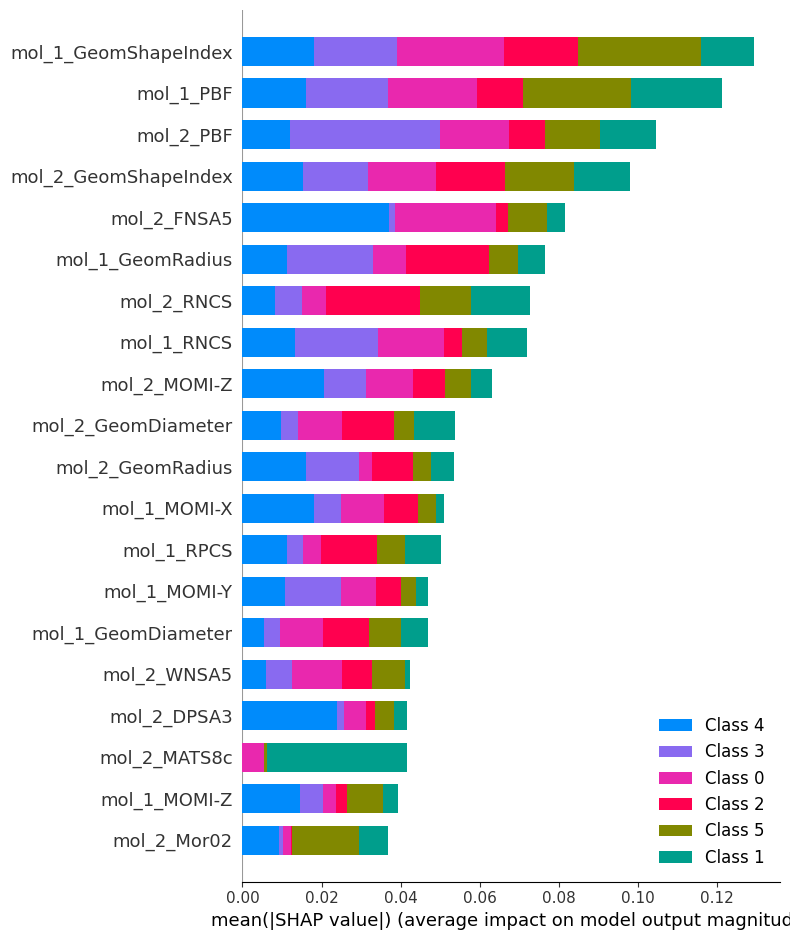

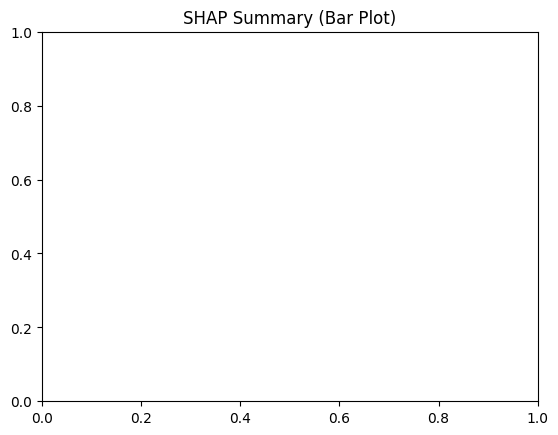

In [1]:
import pickle
import shap
import matplotlib.pyplot as plt

# Load the saved SHAP values and data
with open('/kaggle/working/shap_values_data.pkl', 'rb') as f:
    data = pickle.load(f)

shap_values = data['shap_values']
X_imputed = data['X']

# Generate the SHAP summary bar plot
shap.summary_plot(shap_values, X_imputed, plot_type="bar")
plt.title("SHAP Summary (Bar Plot)")
plt.show()


# Clustering

After removing constant features, 1930 numeric features remain.


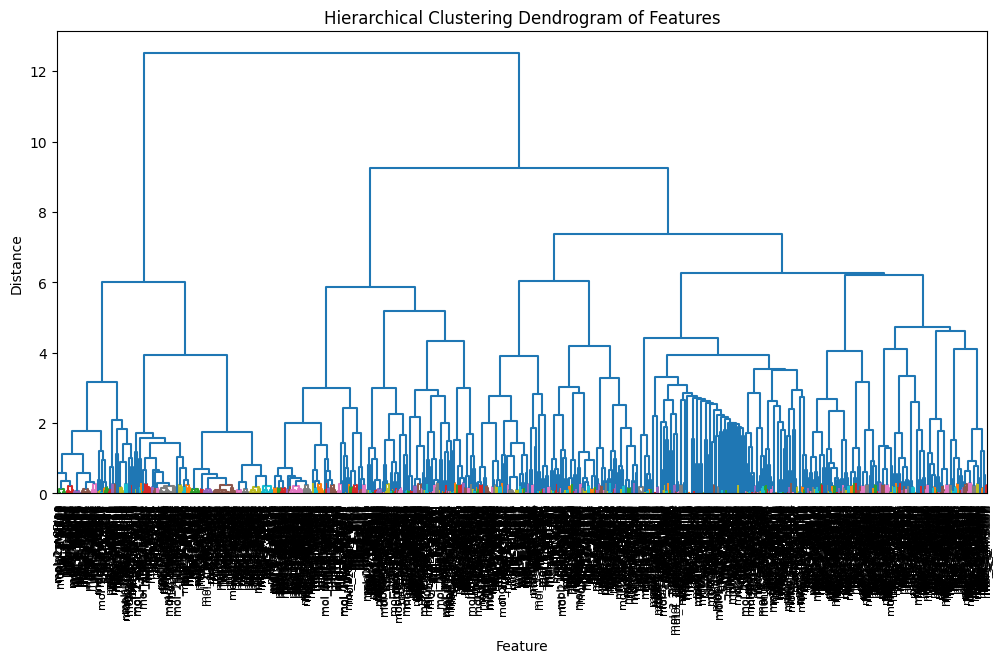

Number of clusters: 2 - Silhouette Score: 0.1006
Number of clusters: 3 - Silhouette Score: 0.1215
Number of clusters: 4 - Silhouette Score: 0.1275
Number of clusters: 5 - Silhouette Score: 0.1418
Number of clusters: 6 - Silhouette Score: 0.1526
Number of clusters: 7 - Silhouette Score: 0.1524
Number of clusters: 8 - Silhouette Score: 0.1229
Number of clusters: 9 - Silhouette Score: 0.1215
Number of clusters: 10 - Silhouette Score: 0.1305
Number of clusters: 11 - Silhouette Score: 0.1388
Number of clusters: 12 - Silhouette Score: 0.1480
Number of clusters: 13 - Silhouette Score: 0.1569
Number of clusters: 14 - Silhouette Score: 0.1652
Number of clusters: 15 - Silhouette Score: 0.1695
Number of clusters: 16 - Silhouette Score: 0.1746
Number of clusters: 17 - Silhouette Score: 0.1825
Number of clusters: 18 - Silhouette Score: 0.1886
Number of clusters: 19 - Silhouette Score: 0.1938
Number of clusters: 20 - Silhouette Score: 0.1768
Number of clusters: 21 - Silhouette Score: 0.1836
Number o

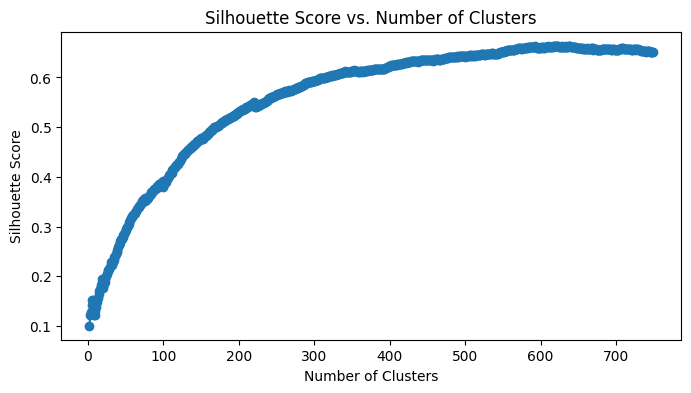

Feature clusters (first 20 rows):
              Feature  Cluster
0           mol_1_ABC       60
1         mol_1_ABCGG       61
2         mol_1_nAcid      425
3         mol_1_nBase      200
4     mol_1_nAromAtom      238
5     mol_1_nAromBond      238
6         mol_1_nAtom       82
7    mol_1_nHeavyAtom       61
8        mol_1_nSpiro       32
9   mol_1_nBridgehead       33
10      mol_1_nHetero      203
11           mol_1_nH       79
12           mol_1_nB      395
13           mol_1_nC       81
14           mol_1_nN      354
15           mol_1_nO      439
16           mol_1_nS      172
17           mol_1_nP      389
18           mol_1_nF      158
19          mol_1_nCl      273
Feature clusters saved to /kaggle/working/feature_clusters.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# 1. Select only numeric columns
X_numeric = X.select_dtypes(include=[np.number])

# 2. Remove constant columns (features with only one unique value)
X_numeric = X_numeric.loc[:, X_numeric.nunique() > 1]
print(f"After removing constant features, {X_numeric.shape[1]} numeric features remain.")

# 3. Compute the correlation matrix and fill NaNs with 0
corr_matrix = X_numeric.corr().abs().fillna(0)
corr_matrix = corr_matrix.clip(0, 1)

# 4. Convert correlation to distance: distance = 1 - correlation
distance_matrix = 1 - corr_matrix
distance_matrix = distance_matrix.clip(lower=0)

# 5. Convert the full distance matrix to a condensed distance matrix for linkage
condensed_distance = squareform(distance_matrix.values)

# 6. Perform hierarchical clustering using the 'ward' method
Z = linkage(condensed_distance, method='ward')

# Plot a dendrogram to visualize the clustering of features
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=X_numeric.columns, leaf_rotation=90, leaf_font_size=8, color_threshold=0.3)
plt.title("Hierarchical Clustering Dendrogram of Features")
plt.xlabel("Feature")
plt.ylabel("Distance")
plt.show()

# -------------------------------------------------------
# Silhouette Score to find the optimal number of clusters
# -------------------------------------------------------
range_n_clusters = range(2, 750)  # e.g.,
silhouette_scores = {}
for n_clusters in range_n_clusters:
    cluster_labels = fcluster(Z, t=n_clusters, criterion='maxclust')
    score = silhouette_score(distance_matrix.values, cluster_labels, metric='precomputed')
    silhouette_scores[n_clusters] = score
    print(f"Number of clusters: {n_clusters} - Silhouette Score: {score:.4f}")

optimal_clusters = max(silhouette_scores, key=silhouette_scores.get)
print(f"Optimal number of clusters based on silhouette score: {optimal_clusters}")

plt.figure(figsize=(8, 4))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

# # -------------------------------------------------------
# # Elbow Method (Within-Cluster Sum of Squares, WCSS)
# # -------------------------------------------------------
# # For WCSS we treat each feature as a vector of its values over the samples.
# # Standardize the features to ensure they are comparable.
# scaler = StandardScaler()
# X_numeric_scaled = scaler.fit_transform(X_numeric)  # shape: (n_samples, n_features)
# # Transpose so that each feature is represented as a vector (row) over the samples
# features_scaled = X_numeric_scaled.T  # shape: (n_features, n_samples)

# wcss = {}
# for n_clusters in range_n_clusters:
#     cluster_labels = fcluster(Z, t=n_clusters, criterion='maxclust')
#     total_wcss = 0
#     # For each cluster, compute the centroid and the sum of squared distances
#     for cluster in np.unique(cluster_labels):
#         indices = np.where(cluster_labels == cluster)[0]  # indices of features in this cluster
#         cluster_features = features_scaled[indices]  # subset of features (rows)
#         centroid = cluster_features.mean(axis=0)
#         distances_squared = np.sum((cluster_features - centroid)**2, axis=1)
#         total_wcss += distances_squared.sum()
#     wcss[n_clusters] = total_wcss
#     print(f"Number of clusters: {n_clusters} - WCSS: {total_wcss:.4f}")

# plt.figure(figsize=(8, 4))
# plt.plot(list(wcss.keys()), list(wcss.values()), marker='o')
# plt.title("Elbow Method (WCSS vs Number of Clusters)")
# plt.xlabel("Number of Clusters")
# plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
# plt.show()

# -------------------------------------------------------
# Use the optimal number of clusters from silhouette analysis 
cluster_labels_optimal = fcluster(Z, t=optimal_clusters, criterion='maxclust')
feature_clusters = pd.DataFrame({'Feature': X_numeric.columns, 'Cluster': cluster_labels_optimal})
print("Feature clusters (first 20 rows):")
print(feature_clusters.head(20))

# Save the complete feature_clusters DataFrame to a CSV file
feature_clusters.to_csv('/kaggle/working/feature_clusters.csv', index=False)
print("Feature clusters saved to /kaggle/working/feature_clusters.csv")


#  Correlation-Based Selection (filter methods)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

def correlation_based_selection(X, threshold=0.90):
   
    X_numeric = X.select_dtypes(include=[np.number])
    corr_matrix = X_numeric.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
    
    return list(X_numeric.columns.difference(to_drop))


selected_numeric_features = correlation_based_selection(X, threshold=0.90)
print(f"Correlation-based selection retained {len(selected_numeric_features)} features.")


selected_features_series = pd.Series(selected_numeric_features, name='Features')
output_path = '/kaggle/working/selected_numeric_features.csv'
selected_features_series.to_csv(output_path, index=False)

print(f"Saved feature list to {output_path}")



# Variance Threshold

In [3]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold



def variance_threshold_selection_preprocessed(X, threshold=0.8):
    
    print("Selecting numeric columns...")
    X_numeric = X.select_dtypes(include=[np.number])
    
    print("Imputing missing values...")
    imputer = SimpleImputer(strategy='mean')
    X_imputed_array = imputer.fit_transform(X_numeric)
    X_imputed = pd.DataFrame(X_imputed_array, columns=X_numeric.columns)
    
    print("Scaling features...")
    scaler = StandardScaler()
    X_scaled_array = scaler.fit_transform(X_imputed)
    X_scaled = pd.DataFrame(X_scaled_array, columns=X_imputed.columns)
    
    print(f"Applying VarianceThreshold with threshold = {threshold}...")
    vt = VarianceThreshold(threshold=threshold)
    vt.fit(X_scaled)
    selected_mask = vt.get_support()
    selected_features = list(X_scaled.columns[selected_mask])
    
    print(f"Variance threshold selection retained {len(selected_features)} features.")
    return selected_features



selected_variance_features = variance_threshold_selection_preprocessed(X, threshold=0.6)
print("Selected features sample:")
print(selected_variance_features[:10])


selected_variance_series = pd.Series(selected_variance_features, name='Features')
output_path = '/kaggle/working/selected_variance_0.6_features.csv'
selected_variance_series.to_csv(output_path, index=False)
print(f"Saved variance feature list to {output_path}")


Selecting numeric columns...
Imputing missing values...
Scaling features...
Applying VarianceThreshold with threshold = 0.6...
Variance threshold selection retained 1930 features.
Selected features sample:
['mol_1_ABC', 'mol_1_ABCGG', 'mol_1_nAcid', 'mol_1_nBase', 'mol_1_nAromAtom', 'mol_1_nAromBond', 'mol_1_nAtom', 'mol_1_nHeavyAtom', 'mol_1_nSpiro', 'mol_1_nBridgehead']
Saved variance feature list to /kaggle/working/selected_variance_0.6_features.csv


# ANOVA 

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# -------------------------------
# Data Preprocessing
# -------------------------------
# Convert all columns in X to numeric (non-convertible values become NaN)
print("Converting columns to numeric...")
X_numeric = X.apply(pd.to_numeric, errors='coerce')

# Drop columns that are entirely NaN
print("Dropping columns that are entirely NaN...")
X_numeric = X_numeric.dropna(axis=1, how='all')
print(f"After conversion, X_numeric has {X_numeric.shape[1]} columns.")

# Impute missing values using the mean strategy
print("Imputing missing values...")
imputer = SimpleImputer(strategy='mean')
X_imputed_array = imputer.fit_transform(X_numeric)
X_imputed = pd.DataFrame(X_imputed_array, columns=X_numeric.columns)

# Scale features to ensure they are on a similar scale
print("Scaling features...")
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X_imputed)
X_scaled = pd.DataFrame(X_scaled_array, columns=X_imputed.columns)

# -------------------------------
# ANOVA Feature Selection
# -------------------------------
k = 650  # You can adjust this number as needed
print(f"Selecting top {k} features using ANOVA F-test...")
selector = SelectKBest(score_func=f_classif, k=k)
selector.fit(X_scaled, y)
selected_mask = selector.get_support()
selected_features = X_scaled.columns[selected_mask]
print(f"ANOVA selection retained {len(selected_features)} features.")
print("Sample of selected features:", selected_features[:10])

# Subset the data to the selected features
X_final = X_scaled[selected_features]

# -------------------------------
# Cross-Validation using RandomForestClassifier
# -------------------------------
print("Performing 5-fold cross-validation with RandomForestClassifier...")
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
cv_scores = cross_val_score(clf, X_final, y, cv=5, scoring='accuracy')
print("Cross-validated accuracies:", cv_scores)
print("Mean cross-validated accuracy:", np.mean(cv_scores))

# Optionally, save the selected feature list to CSV
selected_features_series = pd.Series(selected_features, name='Features')
output_path = '/kaggle/working/anova_selected_features.csv'
selected_features_series.to_csv(output_path, index=False)
print(f"Selected features exported to {output_path}")


Converting columns to numeric...
Dropping columns that are entirely NaN...
After conversion, X_numeric has 3478 columns.
Imputing missing values...
Scaling features...
Selecting top 650 features using ANOVA F-test...


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 918  919  920  921  923  937  939  944  956  957  958  960  961  962
  964  969  972  973  974  975  976  977  978  979  980  981  982  985
  986  988  989  990  991  993  994  995  996  997  998  999 1000 1002
 1016 1018 1023 1035 1036 1037 1039 1040 1041 1043 1048 1051 1052 1053
 1054 1055 1056 1057 1058 1059 1060 1061 1064 1065 1067 1068 1069 1070
 1072 1073 1074 1075 1084 1106 1114 1115 1126 1148 1156 1157 1263 1448
 1458 1556 1563 1568 1569 1570 1571 1572 1573 1575 1576 1579 1580 1581
 1582 1583 1584 1585 1604 1611 1622 1623 1633 1634 1635 1636 1640 1644
 1645 1646 1647 1651 1655 1666 1667 1738 2657 2658 2659 2660 2662 2676
 2678 2683 2695 2696 2697 2699 2700 2701 2703 2708 2711 2712 2713 2714
 2715 2716 2717 2718 2719 2720 2721 2724 2725 2727 2728 2729 2730 2732
 2733 2734 2735 2736 2737 2738 2739 2741 2755 2757 2762 2774 2775 2776
 2778 2779 2780 2782 2787 2790

ANOVA selection retained 650 features.
Sample of selected features: Index(['mol_1_SpMax_A', 'mol_1_SpDiam_A', 'mol_1_nBridgehead', 'mol_1_nN',
       'mol_1_ATS3dv', 'mol_1_ATS4dv', 'mol_1_ATS5dv', 'mol_1_ATS6dv',
       'mol_1_ATS1d', 'mol_1_ATS2d'],
      dtype='object')
Performing 5-fold cross-validation with RandomForestClassifier...
Cross-validated accuracies: [0.16593349 0.16410031 0.16181258 0.16779586 0.18372195]
Mean cross-validated accuracy: 0.16867283882998968
Selected features exported to /kaggle/working/anova_selected_features.csv


# L1 Regularization with Logistic Regression (embedded methods)

In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer

def l1_logistic_selection(X, y, C=0.1, max_iter=1000):
    print("Converting columns to numeric...")
    # Convert all columns to numeric (non-convertible values become NaN)
    X_numeric = X.apply(pd.to_numeric, errors='coerce')
    print("Dropping columns that are entirely NaN...")
    X_numeric = X_numeric.dropna(axis=1, how='all')
    
    print("Imputing missing values using the mean strategy...")
    imputer = SimpleImputer(strategy='mean')
    X_imputed_array = imputer.fit_transform(X_numeric)
    X_imputed = pd.DataFrame(X_imputed_array, columns=X_numeric.columns)
    
    print("Fitting logistic regression with L1 penalty using the 'saga' solver...")
    logreg = LogisticRegression(penalty='l1', solver='saga', max_iter=max_iter, C=C, random_state=42)
    logreg.fit(X_imputed.values, y)
    
    print("Selecting features with non-zero coefficients using L1 regularization...")
    model = SelectFromModel(logreg, prefit=True)
    selected_mask = model.get_support()
    selected_features = X_imputed.columns[selected_mask]
    print("L1 logistic feature selection complete.")
    return selected_features


print("Taking a subsample of the data for feature selection...")
X_sample = X.sample(frac=0.1, random_state=42)
y_sample = y.loc[X_sample.index]
print(f"Subsample size: {X_sample.shape[0]} rows and {X_sample.shape[1]} features.")

# L1 logistic feature selection
l1_features = l1_logistic_selection(X_sample, y_sample, C=0.1, max_iter=1000)
print(f"L1-Logistic selection: {len(l1_features)} features retained.")
print("Selected features sample:")
print(l1_features[:10])


l1_features_series = pd.Series(l1_features, name='Features')
l1_features_series.to_csv('/kaggle/working/l1_features.csv', index=False)
print("Selected features exported to /kaggle/working/l1_features.csv")


Taking a subsample of the data for feature selection...
Subsample size: 5683 rows and 3654 features.
Converting columns to numeric...
Dropping columns that are entirely NaN...
Imputing missing values using the mean strategy...
Fitting logistic regression with L1 penalty using the 'saga' solver...
Selecting features with non-zero coefficients using L1 regularization...
L1 logistic feature selection complete.
L1-Logistic selection: 0 features retained.
Selected features sample:
Index([], dtype='object')
Selected features exported to /kaggle/working/l1_features.csv


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#  Random Forest-Based Selection

In [5]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score

def rf_embedded_selection(X, y, n_features=650):
    # Convert all columns to numeric; non-convertible values become NaN.
    X_numeric = X.apply(pd.to_numeric, errors='coerce')
    # Drop columns that are entirely NaN.
    X_numeric = X_numeric.dropna(axis=1, how='all')
    
    # Impute missing values using the mean strategy.
    imputer = SimpleImputer(strategy='mean')
    X_imputed_array = imputer.fit_transform(X_numeric)
    X_imputed = pd.DataFrame(X_imputed_array, columns=X_numeric.columns)
    
    # Fit RandomForestClassifier.
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_imputed, y)
    
    # Obtain feature importances and sort them.
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_indices = indices[:n_features]
    
    return X_imputed.columns[top_indices]


# ------------------------------
# Run Random Forest Embedded Selection.
# ------------------------------
rf_features = rf_embedded_selection(X, y, n_features=650)
print(f"Random Forest embedded selection: {len(rf_features)} features retained.")
print("Selected features sample:")
print(rf_features[:10])

# Save the selected feature names to CSV.
rf_features_series = pd.Series(rf_features, name='Features')
output_path = '/kaggle/working/rf_features.csv'
rf_features_series.to_csv(output_path, index=False)
print(f"Saved feature list to {output_path}")

# ------------------------------
# Prepare data for cross-validation using the selected features.
# ------------------------------
# Convert X to numeric, drop all-NaN columns, and impute missing values (same as in rf_embedded_selection)
X_numeric = X.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')
imputer = SimpleImputer(strategy='mean')
X_imputed_array = imputer.fit_transform(X_numeric)
X_imputed = pd.DataFrame(X_imputed_array, columns=X_numeric.columns)

# Subset X to only the features selected by the random forest method.
X_final = X_imputed[rf_features]
print(f"X_final has {X_final.shape[0]} rows and {X_final.shape[1]} features.")

# ------------------------------
# Perform 5-fold cross-validation using RandomForestClassifier.
# ------------------------------
rf_cv = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
cv_scores = cross_val_score(rf_cv, X_final, y, cv=5, scoring='accuracy')
print("Cross-validated accuracies:", cv_scores)
print("Mean cross-validated accuracy:", np.mean(cv_scores))


Random Forest embedded selection: 650 features retained.
Selected features sample:
Index(['mol_2_PBF', 'mol_2_GeomShapeIndex', 'mol_2_GeomPetitjeanIndex',
       'mol_1_GeomPetitjeanIndex', 'mol_1_PBF', 'mol_1_GeomShapeIndex',
       'mol_2_GeomRadius', 'mol_1_GeomDiameter', 'mol_1_MOMI-Z',
       'mol_2_GeomDiameter'],
      dtype='object')
Saved feature list to /kaggle/working/rf_features.csv
X_final has 56826 rows and 650 features.
Cross-validated accuracies: [0.16610945 0.16700396 0.16260449 0.16286846 0.16603608]
Mean cross-validated accuracy: 0.1649244855354292


# Boruta Py

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from boruta import BorutaPy
import pickle

print("Converting feature columns to numeric...")
# converting all columns to numeric 
X_numeric = X.apply(pd.to_numeric, errors='coerce')
# dropping columns that are entirely NaN
X_numeric = X_numeric.dropna(axis=1, how='all')
print(f"After conversion and dropping all-NaN columns, X_numeric has {X_numeric.shape[1]} columns.")

print("Imputing missing values with column means...")
imputer = SimpleImputer(strategy='mean')
X_imputed_array = imputer.fit_transform(X_numeric)
X_imputed = pd.DataFrame(X_imputed_array, columns=X_numeric.columns)

# checking for NaNs
if X_imputed.isnull().values.any():
    print("Warning: Some NaNs still remain. Dropping rows with NaN values.")
    X_imputed = X_imputed.dropna()
else:
    print("No missing values remain after imputation.")

# converting to NumPy arrays
X_np = X_imputed.values
y_np = y.loc[X_imputed.index].values


# running Boruta

print("Initializing RandomForestClassifier for Boruta...")
rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=5, random_state=42)

print("Running Boruta feature selection...")
boruta_selector = BorutaPy(estimator=rf, n_estimators='auto', verbose=2, random_state=42)
boruta_selector.fit(X_np, y_np)


selected_features = X_imputed.columns[boruta_selector.support_].tolist()
print(f"Boruta selected {len(selected_features)} features.")
print("Selected features sample:")
print(selected_features[:10])

output_features_path = '/kaggle/working/boruta_selected_features.csv'
pd.Series(selected_features, name='Features').to_csv(output_features_path, index=False)
print(f"Selected features saved to {output_features_path}")


model_output_path = '/kaggle/working/boruta_selector.pkl'
with open(model_output_path, 'wb') as f:
    pickle.dump(boruta_selector, f)
print(f"Boruta model saved to {model_output_path}")

Converting feature columns to numeric...
After conversion and dropping all-NaN columns, X_numeric has 3478 columns.
Imputing missing values with column means...
No missing values remain after imputation.
Initializing RandomForestClassifier for Boruta...
Running Boruta feature selection...
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	3478
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	3478
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	3478
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	3478
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	3478
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	3478
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	3478
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	0
Rejected: 	3478


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	0
Rejected: 	3478
Boruta selected 0 features.
Selected features sample:
[]
Selected features saved to /kaggle/working/boru


# For each subset:
# subset the df with chosen features and target
# convert to H2OFrame and run H2O AutoML
# check performance metrics


In [2]:
def run_automl_on_subset(df, subset_features, target, max_models=10, max_runtime_secs=600):
    # Subset the DataFrame to the chosen features plus the target
    subset_df = df[subset_features + [target]].copy()
    
    # Convert to H2OFrame
    data_h2o = h2o.H2OFrame(subset_df)
    data_h2o[target] = data_h2o[target].asfactor()
    
    # Define feature (x) and target (y) names
    x = subset_features
    y = target
    
    # Train AutoML on the subset
    aml = H2OAutoML(max_models=max_models, max_runtime_secs=max_runtime_secs, seed=42)
    aml.train(x=x, y=y, training_frame=data_h2o)
    
    # Get the leaderboard and best model
    lb = aml.leaderboard
    best_model = aml.leader
    return lb, best_model



corr_features = pd.read_csv("/kaggle/working/selected_numeric_features.csv")["Features"].tolist()
variance_features = pd.read_csv("/kaggle/working/selected_variance_features.csv")["Features"].tolist()
rf_features = pd.read_csv("/kaggle/working/rf_features.csv")["Features"].tolist()

print(f"Correlation-based feature set has {len(corr_features)} features.")
print(f"Variance-based feature set has {len(variance_features)} features.")
print(f"RF-embedded feature set has {len(rf_features)} features.")

# ----------------------------------
# Run H2O AutoML on each feature subset
# ----------------------------------
results = {}

for name, feature_subset in [
    ("corr", corr_features),
    ("variance", variance_features),
    ("rf_embedded", rf_features)
]:
    print(f"\nRunning AutoML for subset: {name} with {len(feature_subset)} features...")
    lb, best_model = run_automl_on_subset(df, feature_subset, target, max_models=10, max_runtime_secs=600)
    results[name] = {
        "leaderboard": lb,
        "best_model": best_model
    }
    print(lb.head(rows=lb.nrows))
    print(f"Best model for {name}: {best_model.model_id}")


Correlation-based feature set has 721 features.
Variance-based feature set has 1930 features.
RF-embedded feature set has 100 features.

Running AutoML for subset: corr with 721 features...
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |████████████████████████████████████
06:32:57.266: _train param, Dropping bad and constant columns: [mol_1_n12aRing, mol_2_SssssPb, mol_2_nG12aRing, mol_2_SssGeH2, mol_1_NssssB, mol_1_SsssSiH, mol_1_n8AHRing, mol_1_NsPbH3, mol_1_SsSiH3, mol_1_n6FaRing, mol_1_SsssNH, mol_2_n11aRing, mol_1_SsLi, mol_1_NsssAs, mol_2_n4FAHRing, mol_1_NsSnH3, mol_1_NssssSn, mol_1_NsPH2, mol_1_n4aHRing, mol_2_SssPH, mol_2_n4FARing, mol_1_SssBH, mol_1_n4FRing, mol_2_n8aHRing, mol_2_nG12aHRing, mol_1_SsssP, mol_1_SsssPbH, mol_2_n4FaRing, mol_2_SsssdAs, mol_2_SsNH3, mol_1_NsLi, mol_1_nG12aHRing, mol_2_n4FHRing, mol_1_nG12aRing, mol_2_SssPbH2, mol_1_SsSeH, mol_1_SssBe, mol_1_NsssSiH, mol_1_n5FaRing, mol_2_n3aHRing,

Comaring performance

In [ ]:
for name, res in results.items():
    lb = res["leaderboard"]
    best_model = res["best_model"]
    # Convert leaderboard to a pandas DataFrame to see metrics
    lb_df = lb.as_data_frame()
    print(f"\nSubset: {name}")
    print(lb_df.head())
    # or print out a particular metric from the best_model:
    # e.g., best_model.auc() for binary classification, or best_model.mean_per_class_error() for multiclass
